In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

In [9]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)

In [10]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [11]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4220, 4215, 4206, 4193, 4213, 4207, 4175, 4199, 4192, 4180]
test groups: [1780, 1785, 1794, 1807, 1787, 1793, 1825, 1801, 1808, 1820]


In [12]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D,
Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')
    (n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
    n_layer = Flatten()(n_layer)
    n_layer = Dense(32, activation = 'linear')(n_layer)
    n_layer = Dropout(0.5)(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    feature_model = Model(inputs = [img_in], outputs = [n_layer], name =
'FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatureNet_ImageInput (Inpu  [(None, 28, 28, 1)]      0         
 tLayer)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 96)         384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 256)         614656    
                                            

In [13]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()


Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 10)          21604426    ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['FeatureGeneratio

In [14]:
from tensorflow.keras.optimizers import Adam,SGD
opt = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
similarity_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'mae'])

In [15]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [16]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,
        m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

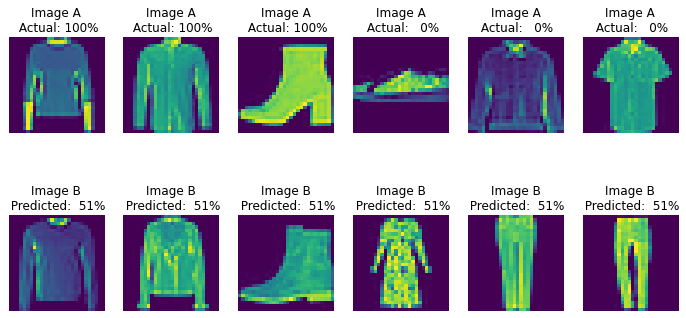

In [17]:
#untrained model
_ = show_model_output()

In [18]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 [==============================] - 211s 419ms/step - loss: 0.6026 - accuracy: 0.6864 - mae: 0.4218 - val_loss: 0.5335 - val_accuracy: 0.7339 - val_mae: 0.3679
Epoch 2/10
500/500 [==============================] - 210s 420ms/step - loss: 0.5208 - accuracy: 0.7215 - mae: 0.3582 - val_loss: 0.4764 - val_accuracy: 0.7432 - val_mae: 0.3199
Epoch 3/10
500/500 [==============================] - 215s 430ms/step - loss: 0.4549 - accuracy: 0.7736 - mae: 0.3080 - val_loss: 0.4304 - val_accuracy: 0.7803 - val_mae: 0.2966
Epoch 4/10
500/500 [==============================] - 244s 487ms/step - loss: 0.4411 - accuracy: 0.7800 - mae: 0.2957 - val_loss: 0.4161 - val_accuracy: 0.7852 - val_mae: 0.2857
Epoch 5/10
500/500 [==============================] - 269s 538ms/step - loss: 0.4400 - accuracy: 0.7781 - mae: 0.2951 - val_loss: 0.4318 - val_accuracy: 0.7754 - val_mae: 0.2937
Epoch 6/10
500/500 [==============================] - 254s 508ms/step - loss: 0.4331 - accuracy: 0.7822 - mae:

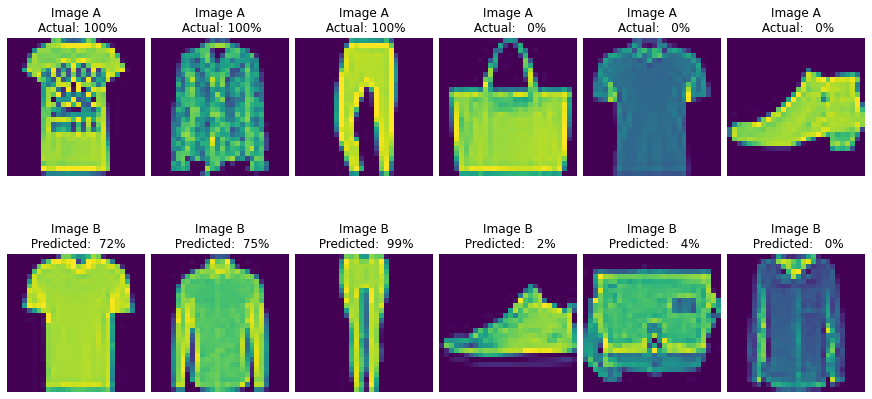

In [20]:
_ = show_model_output()

In [21]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0], 0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0], 0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose=True, batch_size=128)

79/79 [==============================] - 4s 44ms/step


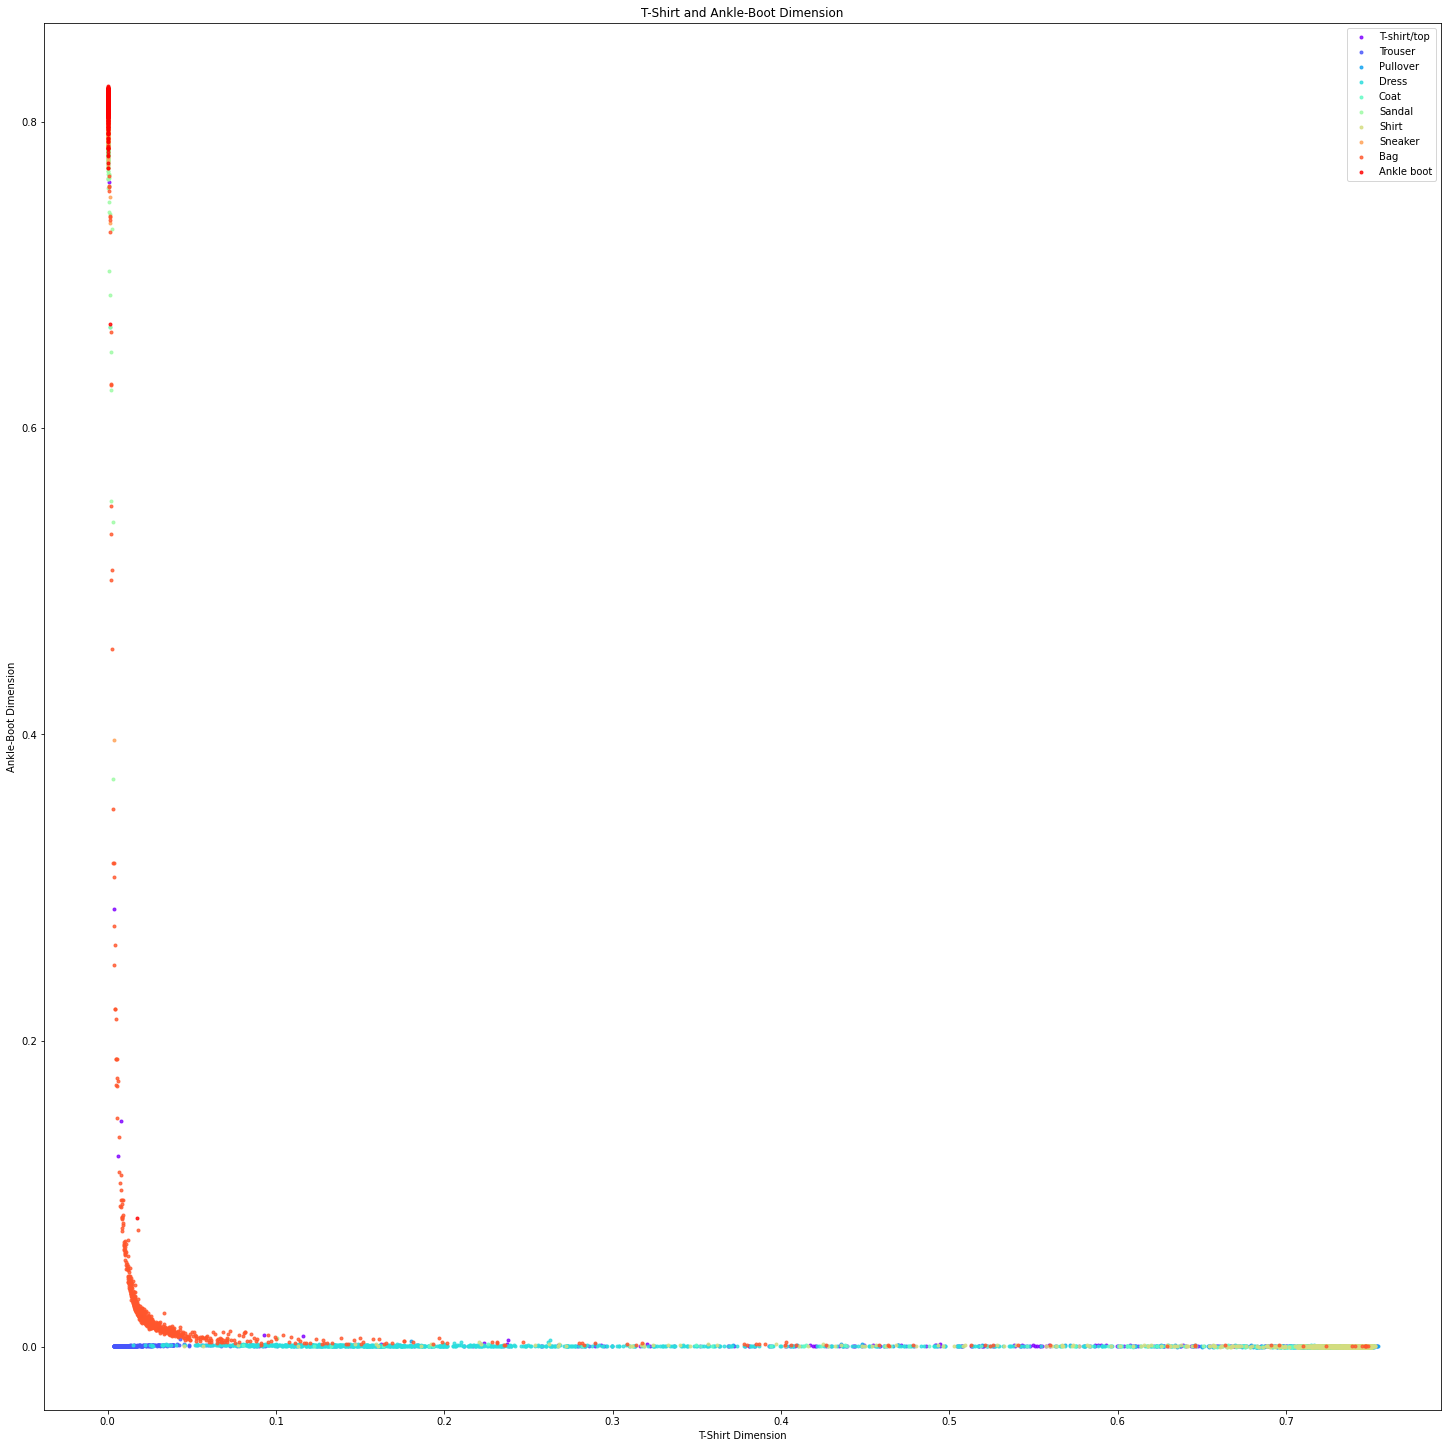

In [22]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.show(block=False)

In [23]:
x_test_features = feature_model.predict(
    x_test,
    verbose=True,
    batch_size=128
)

79/79 [==============================] - 3s 28ms/step


In [24]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

C:\Users\andri\anaconda3\envs\pytorch_p37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 5.961s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.118435
[t-SNE] Computed conditional probabilities in 0.780s


C:\Users\andri\anaconda3\envs\pytorch_p37\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 76.7856522, gradient norm = 0.0026891 (50 iterations in 5.515s)
[t-SNE] Iteration 100: error = 75.4842072, gradient norm = 0.0015800 (50 iterations in 5.449s)
[t-SNE] Iteration 150: error = 74.8572235, gradient norm = 0.0012383 (50 iterations in 4.432s)
[t-SNE] Iteration 200: error = 74.4749374, gradient norm = 0.0008900 (50 iterations in 5.434s)
[t-SNE] Iteration 250: error = 74.2137909, gradient norm = 0.0007503 (50 iterations in 5.444s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.213791
[t-SNE] Iteration 300: error = 2.6308796, gradient norm = 0.0012936 (50 iterations in 4.443s)
[t-SNE] Iteration 350: error = 2.1443551, gradient norm = 0.0005877 (50 iterations in 5.590s)
[t-SNE] Iteration 400: error = 1.9010756, gradient norm = 0.0003485 (50 iterations in 5.674s)
[t-SNE] Iteration 450: error = 1.7588671, gradient norm = 0.0002370 (50 iterations in 4.495s)
[t-SNE] Iteration 500: error = 1.6651369, gradient norm = 0.0001771 (50 

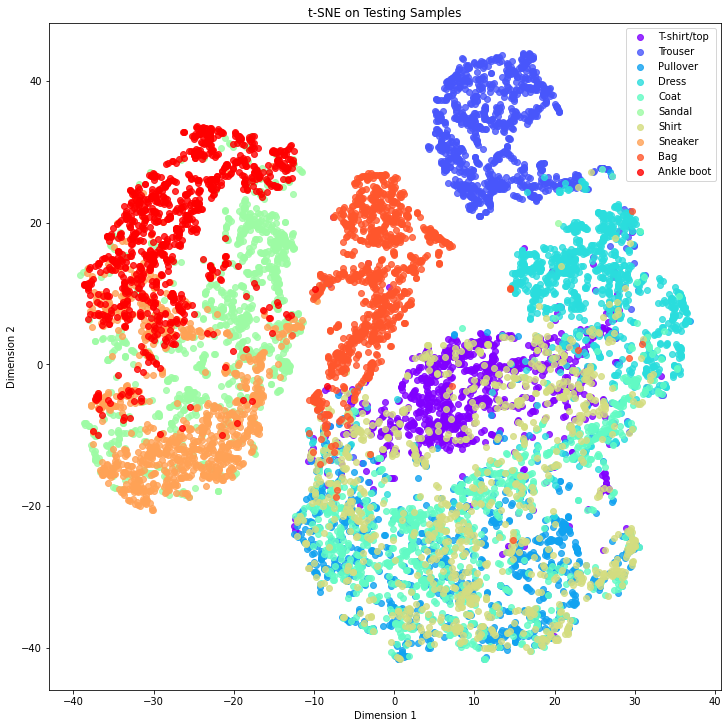

In [25]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)